# Métricas en modelos supervisados de regresión

En problemas de regresión existen muchas métricas distintas, pero a diferencia de los problemas de clasificación, no siempre son fáciles de interpretar a simple vista. Por ejemplo, en clasificación, la biblioteca más utilizada para machine learning —scikit-learn— nos ofrece un reporte muy claro con la función classification_report, que muestra las métricas más importantes de forma organizada.

En este notebook veremos las principales métricas para regresión, cómo funcionan, cuáles son sus ventajas y desventajas, en qué casos se suelen usar y cómo interpretarlas correctamente.

Además, crearemos una función que genere un reporte de métricas de regresión, inspirado en el de clasificación, para que podamos ver de forma clara los resultados de nuestros modelos.

Aunque hay muchas formas de clasificar las métricas de regresión, podemos usar un enfoque práctico considerando cuatro aspectos clave:

1.	Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?
2. Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?
3.	Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.
4.	Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.
5.	Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.


Analizar estas cuatro dimensiones nos ayuda a elegir métricas que sean coherentes tanto con la naturaleza de nuestros datos —lo que identificamos en el EDA— como con los objetivos del problema.

Para poder aplicar estos criterios, primero definiremos brevemente cada uno y luego los desarrollaremos al explicar cada métrica principal.

## Criterios para clasificar metricas de regresión

### Criterio basado rol o uso en el ciclo de modelado



1. **Optimización (Loss / entrenamiento):**  Propósito principal es guiar los parámetros del modelo hacia predicciones más precisas, priorizando eficiencia computacional y estabilidad numérica.

1. **Evaluación / Reporting (Metrics / scoring):** El propósito principal es medir el desempeño del modelo y comunicar resultados de manera clara, priorizando interpretabilidad y comparabilidad, incluso si no son diferenciables.

La métrica que se optimiza durante el entrenamiento no siempre coincide con la métrica utilizada para evaluación o reporting.  
Por ejemplo, un modelo puede entrenarse con **MSE** pero evaluarse con **MAE** para obtener una medida más interpretable.

Si bien ambos grupos requieren estabilidad numérica en el dominio de los datos para asegurar robustez en el cálculo de la métrica, en las métricas de optimización este requisito suele ser más crítico debido a su impacto directo en la convergencia del entrenamiento.  

Hay ciertas particularidades de requisitos para cada subgrupo:

#### Optimización (Loss / entrenamiento)

- Diferenciables o sub-diferenciables, para permitir optimización eficiente.  
- Suaves y continuas, para que los gradientes sean estables durante el entrenamiento, especialmente si se utiliza algún algoritmo iterativo y de retropropagación como el descenso por gradiente.

#### Evaluación / Reporting (Metrics / scoring)

- Interpretables y comprensibles, útiles para análisis y decisiones de negocio.  
- Comparables entre modelos y datasets, considerando unidades y escalas.

### Crieterio de Dependencia y normalización de escala



Este criterio clasifica las métricas de evaluación según cómo se relacionan con la escala del *target* y si su valor es:

- Dependiente de unidades  
- Normalizable  
- Intrínsecamente adimensional  

**Clasificación clara**

#### Métricas dependientes de escala (no porcentuales)

Estas métricas:

- Se expresan en las mismas unidades del *target*.  
- No son porcentuales.  
- No son comparables entre datasets con distinta escala.  

**Ejemplo conceptual:**  
Si el *target* está en dólares → el error está en dólares.

Para convertirlas en porcentaje, debes dividirlas por una escala de referencia (media, rango, IQR, etc.).


#### Métricas normalizadas externamente

Son métricas dependientes de escala que pueden convertirse en adimensionales dividiéndolas por una medida global del dataset. Normalizar externamente es equivalente a redefinir la unidad de medida, es como estar diciendo: “1 unidad de error = X unidades de variabilidad del fenómeno”

El divisor define qué entiendes por “variabilidad”.

$$
\mathrm{Error\ normalizado} =
\frac{\mathrm{Metrica\ base}}{\mathrm{Escala\ de\ referencia}}
$$

**Escalas posibles:**

* Media del target: cuando el nivel promedio es estable y significativo (p. ej., ventas, ingresos) y quieres interpretar el error como % del valor típico.
* Rango $(\max - \min)$: cuando no hay outliers fuertes y necesitas una escala acotada y fácilmente interpretable entre datasets similares.
* IQR: cuando la distribución es asimétrica o tiene outliers y quieres una normalización robusta centrada en la dispersión típica.
* Desviación estándar: cuando buscas comparabilidad estadística y relacionar el error con la variabilidad natural del fenómeno (conexión con $R^2$).
* Valor de un modelo baseline: cuando quieres medir mejora relativa real respecto a una referencia (ej. media histórica) y evaluar ganancia predictiva práctica.

Aquí el porcentaje lo defines tú.

**Importante:**  
La elección de la escala cambia la interpretación.


#### Métricas intrínsecamente relativas (adimensionales)

Estas métricas ya están definidas como proporciones.

- No dependen de unidades.  
- Se interpretan directamente como porcentaje o proporción.  
- Son inherentemente comparables entre problemas.  

Aquí no necesitas normalización adicional.

### Criterio sobre supuestos estructurales



Toda métrica de regresión está construida bajo ciertas condiciones implícitas o explícitas sobre los datos, tales como:

- Distribución del error. Es la forma en que se comportan los residuos: $e_i = y_i - \hat{y}_i$, si haces un histograma de los $e_i$, eso es la distribución del error.

Algunas métricas asumen que los errores siguen una distribución específica (por ejemplo, simétrica o con varianza finita), lo que condiciona cómo se agregan y ponderan los errores. Si esta suposición no se cumple, la métrica puede distorsionar la evaluación del modelo y perder interpretabilidad. 

- Escala del target. La magnitud de los valores de salida afecta directamente el cálculo de ciertas métricas. Si la métrica asume una escala particular y los datos están en otra, los errores pueden parecer desproporcionadamente grandes o pequeños, dificultando la comparación y la interpretación.

- Estructura del error (aditiva o multiplicativa). Aquí hablamos de cómo se genera el error en el fenómeno real. Algunas métricas consideran que los errores se suman linealmente sobre el valor real, mientras que otras asumen que los errores se escalan proporcionalmente al valor. Si esta estructura no coincide con la realidad, la métrica puede sobreestimar o subestimar el impacto de los errores.
  - Error aditivo: $y = f(x) + \varepsilon$, el error se suma en unidades absolutas (ej: Temperatura: ±2°C, Peso: ±3 kg, etc). El error no depende del tamaño del valor, por lo que el error no crece cuando el valor crece.
  - Error multiplicativo:$ y = f(x) \cdot (1 + \varepsilon)$, el error es proporcional al valor (ej: Ventas: 10% de error, Precio de vivienda: 8% de error, etc.). Aquí el error crece cuando el valor crece.

- Dominio permitido de los valores (positivos, no nulos, acotados, etc.). Muchas métricas requieren que los datos se encuentren dentro de ciertos rangos o que no incluyan valores prohibidos, como ceros o negativos. Si los datos violan estas restricciones, pueden producirse operaciones indefinidas, resultados explosivos o errores computacionales.

#### Consecuencias de violar los supuestos

Si los datos no cumplen los supuestos implícitos de una métrica, pueden surgir 3 tipos de problemas distintos:

A. Problemas de validez e interpretación

Si los supuestos de la métrica no se cumplen:
* Algunas operaciones pueden ser inválidas (por ejemplo, división por cero en MAPE o logaritmos negativos).
* La métrica puede amplificar o minimizar ciertos errores de manera estructural (por ejemplo, el cuadrado en MSE o denominadores pequeños en errores relativos).
* El valor calculado puede ser matemáticamente correcto pero no reflejar adecuadamente el desempeño real del modelo, perdiendo interpretabilidad estadística y relevancia práctica.

B. Independientemente de su validez estadística, un problema puede volverse mal condicionado cuando pequeñas perturbaciones en los datos producen grandes variaciones en el resultado.

En aritmética de punto flotante (≈15–16 dígitos en float64), los errores de redondeo pueden amplificarse cuando:
* Existen restas entre números muy cercanos (cancelación numérica).
* Se operan valores de magnitudes muy diferentes.
* El sistema tiene alto número de condición.

En estos casos, la precisión efectiva se reduce y la métrica puede volverse numéricamente inestable.

#### Relación entre estabilidad e interpretación

La estabilidad numérica afecta la confiabilidad del valor calculado.
Los supuestos afectan el significado de ese valor.

Cuando ambos fallan simultáneamente, la métrica puede volverse tanto computacionalmente inestable como conceptualmente engañosa. Sin embargo, la pérdida de interpretabilidad no se deriva exclusivamente de la inestabilidad numérica, sino principalmente de la ruptura de los supuestos que fundamentan la métrica.

### Estabilidad condicionamiento matematico y estabilidad computacional



La estabilidad numérica determina si podemos confiar en el valor de error reportado. Un valor de métrica inestable no solo es inexacto; es engañoso, ya que pequeñas variaciones en las predicciones (ruido) pueden disparar el error de forma artificial.

Se analiza bajo dos dimensiones críticas:

1. El **condicionamiento matemático** de la función referente a la metrica, que determina la sensibilidad intrínseca para el conjunto de datos.
2. La **estabilidad computacional** de su implementación, que determina qué tan fielmente el algoritmo computacional respeta esa sensibilidad bajo precisión finita.

Una métrica adecuadamente diseñada debe:

- Estar **bien condicionada** en el dominio relevante de los datos.
- Poder calcularse de forma **robusta bajo aritmética de precisión finita**.

#### Condicionamiento matemático

El condicionamiento es una propiedad intrínseca de la fórmula. Define qué tan "nerviosa" es la métrica ante cambios mínimos en los datos de entrada ($y$ o $\hat{y}$). Una métrica está mal condicionada si un cambio infinitesimal en la entrada provoca un cambio masivo en la salida.

- El Número de Condición ($\kappa$): Para una métrica $f(x)$, el número de condición relativo mide la amplificación del error: 

$$\kappa(x) = \left| \frac{x \cdot f'(x)}{f(x)} \right|$$

  - $\kappa \approx 1$: Bien condicionado (estable).
  - $\kappa \gg 1$: Mal condicionado (peligroso).

Ejemplo muy claro es el de la metrica MAPE (Mean Absolute Percentage Error). Cuando el valor real $y_i$ se acerca a cero, la derivada tiende a infinito, haciendo que la métrica sea extremadamente sensible a valores pequeños, perdiendo representatividad global.

#### Estabilidad computacional

A diferencia del condicionamiento, que es una propiedad teórica de la función, la estabilidad computacional se refiere a cómo el algoritmo de cálculo interactúa con la arquitectura del hardware. En Ciencia de Datos, operamos bajo el estándar IEEE 754 (Aritmética de Punto Flotante), lo que significa que no representamos números reales, sino aproximaciones discretas en base 2 con bits limitados.

Una implementación es inestable si el error de redondeo generado en cada paso se magnifica, destruyendo la precisión del resultado final, incluso si la métrica está perfectamente condicionada. Existen 3 "Patógenos" principale de la Inestabilidad:

* Cancelación Catastrófica (El riesgo de las diferencias): Ocurre cuando restamos dos números casi idénticos de gran magnitud. Al hacerlo, los dígitos significativos que coinciden se anulan, y el resultado queda dominado por los errores de redondeo que antes estaban en las posiciones menos significativas. En Regresión aparece típicamente al calcular la Varianza de los Errores o el R² mediante la "fórmula de una sola pasada" ($\sum y^2 - n\bar{y}^2$). Si los valores de $y$ son muy grandes y su variabilidad es mínima, la resta producirá basura numérica.

* Desbordamiento (Overflow) y Subdesbordamiento (Underflow): Bajo precisión finita (p. ej., float64), existe un rango estricto de valores representables (aprox. $10^{-308}$ a $10^{308}$).
  * Overflow: Al calcular el MSE (Mean Squared Error) en datasets con outliers extremos, elevar el error al cuadrado puede superar el límite del exponente, devolviendo inf.
  * Underflow: En métricas que involucran probabilidades o productos (como la Log-Loss en regresión logística), los valores pueden volverse tan pequeños que el hardware los redondea a un 0 absoluto, provocando errores de división por cero o logaritmos de cero en pasos posteriores.
* Acumulación de Sesgo por Redondeo (Error de Sumación): En entornos de Big Data, sumar millones de términos (como en el cálculo del MAE o MSE global) de forma ingenua (for loop simple) es peligroso. El error de redondeo cometido al sumar un número pequeño a un acumulador ya muy grande puede sesgar sistemáticamente el resultado hacia abajo. La métrica reportada será menor que el error real, dándote una falsa sensación de precisión en el modelo.

Delegar el cálculo en librerías como scikit-learn, NumPy o PyTorch no es solo por comodidad o velocidad; es una medida de seguridad algorítmica. Estas librerías no son simples envoltorios de fórmulas; son implementaciones refinadas durante décadas para sobrevivir a los "patógenos" que mencionamos antes. Igualmente hay dos escenarios donde la librería no es suficiente:

* La Escala de los Datos (El verdadero antídoto es el Scaling)Si pasas valores de $y$ que oscilan entre $10^{-15}$ y $10^{15}$ a una función de error cuadrático (MSE), incluso la mejor librería del mundo sufrirá. El cuadrado de $10^{15}$ es $10^{30}$, y sumarlo a $10^{-15}$ causará una pérdida total de precisión por la diferencia de magnitudes. Aqui la solución es una simple normalización o Estandarización de datos antes de entrenar y evaluar.

* El Tipo de Dato (Dtype): Si por ahorrar memoria conviertes tus arrays a float16 o float32 antes de llamar a sklearn, estás limitando la "caja de herramientas" de la librería. Aqui la solucion es simplemente mantener float64 para el cálculo de métricas críticas de evaluación, incluso si el entrenamiento se hizo en precisión media.

### Criterio de Simetría y Asimetría del Error



La simetría del error define la "política de castigo" de una métrica. Determina si el modelo debe ser agnóstico al signo del error o si debe priorizar la corrección de sesgos específicos (sobreestimación vs. subestimación).

#### Simetría de Magnitud (Métricas Absolutas)

Estas métricas tratan los errores de igual forma siempre que su distancia al valor real sea la misma. Son útiles cuando el costo del error es lineal o cuadrático respecto a la unidad de medida.

* Propiedad: $f(y, \hat{y}) = f(|y - \hat{y}|)$.

* Comportamiento: Un error de $+10$ unidades tiene el mismo impacto que uno de $-10$.

* Ejemplos: MAE (Mean Absolute Error) y MSE (Mean Squared Error).Uso ideal: Problemas donde el signo del error no cambia la decisión operativa (ej. predecir la temperatura de una habitación para confort general).


#### Asimetría de Escala (Métricas Relativas o Porcentuales)
Aquí es donde ocurre la confusión común. Aunque el concepto busca "equidad" (un error de 10 sobre 100 es "lo mismo" que 1 sobre 10), matemáticamente introducen un sesgo hacia la subestimación.

Ejemplos: El problema del MAPE y WAPE, como el valor real $y$ está en el denominador, la métrica es extremadamente sensible cuando $y$ es pequeño. Si $y=100$ y predigo $\hat{y}=150$, el error es $50\%$; si $y=100$ y predigo $\hat{y}=50$, el error es $50\%$; pero, si el valor real cae cerca de cero, cualquier sobreestimación dispara la métrica hacia el infinito, mientras que la subestimación está acotada al $100\%$. Para recuperar la simetría en términos relativos, se usa el sMAPE (Symmetric MAPE) o se trabaja en el dominio logarítmico (MSLE).

#### Asimetría Dirigida (Métricas de Costo o de Negocio)
En muchos escenarios reales, no todos los errores cuestan lo mismo. La asimetría es una decisión de diseño para forzar al modelo a ser "precavido".

* Subestimación > Sobreestimación: En la predicción de demanda de inventario de productos perecederos, quedarte corto (subestimar) significa pérdida de venta y cliente; sobrar (sobreestimar) solo es costo de almacenamiento.

* Sobreestimación > Subestimación: En la predicción de tiempos de llegada de un vuelo, es mejor llegar "antes" de lo previsto que "después".

* Implementación: Se utilizan funciones de pérdida como la Pinball Loss (usada en Regresión Cuantílica) o funciones de costo lineal asimétrico.

## Principales metricas

En la práctica de la ciencia de datos, no evaluamos por el simple hecho de obtener un número. Evaluamos para entender el riesgo, la magnitud del error y el impacto económico de nuestras predicciones. Dado que existen múltiples formas de medir la diferencia entre el valor real ($y$) y la predicción ($\hat{y}$), analizaremos las métricas de reporting más distintivas bajo los 5 criterios que desarrollamos previamente. El objetivo es que el cientifico o cientifica de datos sea capaz de seleccionar la métrica que mejor traduzca el rendimiento del modelo al lenguaje de la toma de decisiones; en este sentido, priorizaremos los subtipos de metricas de reporte.

### MSE y RMSE

####  Fórmula

MSE

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

RMSE:

$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$


#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

MSE usan principalmente para optimización de modelos (por ejemplo, como función de pérdida en regresión lineal) ya que cuantifican el error promedio cuadrático, y este no representa la escala real de los datos, sino que la eleva al 2.

RMSE tiene la ventaja de estar en las mismas unidades que la variable objetivo, lo que facilita la interpretación directa y su uso tambien en reporting.

#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

Las métricas de error como el MSE y el RMSE dependen directamente de las unidades de la variable objetivo: si y está medida en cierta unidad, el MSE quedará expresado en esa unidad al cuadrado y el RMSE en la misma unidad original, por lo que no son adimensionales por naturaleza y su magnitud solo puede interpretarse en el contexto de la escala de los datos. Esta dependencia implica que no siempre es adecuado comparar directamente estos valores entre distintos problemas o conjuntos de datos con escalas diferentes; por ello, en muchos casos se recurre a versiones normalizadas, como el RMSE dividido por el rango, la media u otra medida representativa de y, obteniendo así una métrica relativa que permite interpretar el error en términos proporcionales y facilita la comparación entre modelos o contextos distintos.

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

Las métricas de error no requieren que los datos ni los errores sigan una distribución normal estricta, pero sí asumen que los errores $(e_i = y_i - \hat{y}_i)$ se distribuyen de manera aproximadamente simétrica alrededor de cero, es decir, que no exista un sesgo sistemático y que haya tanto errores positivos como negativos, de modo que la media de los errores esté cercana a cero. Esta simetría es importante porque, aunque métricas como MSE o RMSE cuantifican la magnitud de los errores, no distinguen su dirección; si todos los errores tuvieran el mismo signo, la métrica podría dar la falsa sensación de precisión.

#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

la sensibilidad a outliers es el problema más evidente y estudiado, pero la estabilidad numérica de MSE y RMSE también depende de la escala de los datos, el tamaño de la muestra y la independencia de los errores.

1.	Escala de los datos: Si los valores de y son muy grandes, los errores al cuadrado pueden volverse muy grandes, y pequeñas diferencias en los datos pueden generar grandes cambios en el MSE/RMSE. Esto también puede causar problemas de representación numérica en computadores de precisión limitada.

2.	Cantidad de datos: MSE y RMSE son promedios de los errores al cuadrado, por lo que con muestras pequeñas la métrica puede ser muy inestable: un solo error grande puede dominar la métrica, mientras que en muestras grandes esto se amortigua.

3.	Errores correlacionados o no independientes: Si los errores tienen correlaciones fuertes entre sí (por ejemplo, un patrón sistemático), la métrica puede dar valores que no reflejan la verdadera dispersión “promedio” de los errores y variar según la selección de subconjuntos de datos. Por ejemplo, supongamos que tienes un modelo que predice temperaturas diarias:

- Día 1: error = +2 °C
- Día 2: error = +1.8 °C
- Día 3: error = +2.1 °C

#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

Son simétricos, ya que al elevar al cuadrado los errores, tratan por igual los errores positivos y negativos. Penalizando fuertemente los errores grandes (muy positivos o muy negativos) debido a la cuadratura, por lo que destacan las predicciones muy alejadas de los valores reales.


### RMSLE


#### Formula

La métrica RMSLE (Root Mean Squared Logarithmic Error) se define como:

$$
\text{RMSLE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \left( \log(1 + y_i) - \log(1 + \hat{y}_i) \right)^2 }
$$

El uso de $\log(1 + y)$ permite evitar problemas cuando $y_i = 0$.

#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

Puede utilizarse tanto para optimización (definiendo la pérdida en escala logarítmica) como para evaluación/reporting.

#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

Bajo el criterio de Dependencia y normalización de escala, el RMSLE es intrínsecamente adimensional porque calcula el error sobre los logaritmos de los valores predichos y observados, lo que elimina la influencia directa de las unidades originales, ya sea metros, dólares u otra medida. En lugar de medir diferencias absolutas, el logaritmo transforma las relaciones multiplicativas en sumas, de manera que la métrica refleja el factor relativo entre predicción y valor real. Por ejemplo, si el valor real es 10 y la predicción 20, el error logarítmico es $\log(20)-\log(10)=\log(2)$; si el valor real es 1000 y la predicción 2000, el error sigue siendo $\log(2)$, aunque la diferencia absoluta sea mucho mayor. Esto hace que los errores relativos sean consistentes incluso cuando los valores varían en órdenes de magnitud, lo que permite comparar modelos en problemas con distintas escalas, siempre que las variables sean positivas.

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

RMSLE no tiene supuestos sobre normalidad, simetría de errores o independencia, como sí ocurre con métricas basadas en errores absolutos o cuadrados; sus restricciones son principalmente de positividad y coherencia multiplicativa de los errores. Si tus datos son todos positivos, tienen rangos amplios y los errores tienden a ser proporcionales a los valores RMSLE es muy apta.

1.	Valores positivos: Como RMSLE aplica el logaritmo, requiere que $y_i \ge 0$ y $ \hat{y}_i \ge 0$. Para incluir ceros, se suele usar $\log(y+1)$. Esto es un requisito matemático del logaritmo y no un supuesto sobre el modelo en sí.

2.	Errores multiplicativos: RMSLE mide diferencias logarítmicas, lo que equivale a capturar factores relativos o multiplicativos entre la predicción y el valor real. Por ejemplo, predecir el doble de un valor siempre produce el mismo error logarítmico, sin importar la magnitud absoluta. Por eso es coherente cuando los errores tienen efecto multiplicativo, no aditivo. Cómo identificarlo en tus datos:
	*	Grafica $y_pred$ vs $y_real$: si los puntos se dispersan proporcionalmente al valor (mayor dispersión en valores grandes), probablemente los errores son multiplicativos.
	*	Calcula $(y_pred - y_real)/y_real$ (error relativo): si estos valores son más constantes que los errores absolutos, RMSLE es adecuado.

3.	Escala logarítmica relevante: Implícitamente, RMSLE asume que interpretar el problema en escala logarítmica tiene sentido, como ocurre con crecimientos porcentuales, incrementos relativos o datos que varían varios órdenes de magnitud. Si los datos no tienen sentido en escala log, la métrica puede no reflejar adecuadamente la calidad de las predicciones. RMSLE solo tiene sentido si los datos varían en órdenes de magnitud (10, 100, 1000…); si tus datos son todos del mismo orden (por ejemplo, entre 5 y 10), RMSLE puede ser menos útil: la transformación logarítmica no cambia mucho y la métrica pierde interpretación. Cómo identificarlo en tus datos: Revisa el rango y la dispersión: Si $\max(y)/\min(y) > 10$, la escala logarítmica es relevante.

#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

RMSLE tiene menor sensibilidad a outliers grandes, el logaritmo comprime los valores grandes, por lo que un error absoluto enorme en escala original no inflará tanto la métrica como lo haría RMSE. Por eso RMSLE suele ser más estable en distribuciones muy sesgadas hacia la derecha siendo más estable frente a outliers grandes, pero puede ser sensible a valores cercanos a cero, errores relativos extremos y cualquier valor negativo, lo que constituye sus principales problemas de estabilidad numérica.

1.	Sensibilidad a valores pequeños o ceros: RMSLE puede ser inestable cuando los valores reales son cercanos a cero, porque el logaritmo amplifica las diferencias relativas. Por eso se suele usar $\log(y + 1)$ para evitar $log(0)$, pero aún así errores pequeños en valores cercanos a cero pueden generar impactos relativamente grandes en la métrica.

2.	Dependencia de la positividad de los datos: Al requerir $y_i \ge 0$ y $\hat{y}_i \ge 0$, cualquier valor negativo (por error de medición, predicción o transformación) rompe la métrica. Esto no es exactamente un “outlier”, pero sí un factor de inestabilidad numérica.

3.	Errores relativos extremos en valores pequeños: Si un conjunto tiene muchos valores pequeños y uno de ellos es predicho muy mal, RMSLE puede verse desproporcionadamente afectado, porque el logaritmo enfatiza la relación relativa $(\hat{y}-y)/y$.

#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

Es simétrica en escala logarítmica, no en escala original, penalizando más los errores relativos grandes que los pequeños, reduciendo el peso de errores extremadamente grandes en términos absolutos (sin importar si son negativos o positivos), comparado con MSE/RMSE.

### Mean absolute error

#### Formula

La métrica MAE (Mean Absolute Error) se define como:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

Mide el promedio del valor absoluto de los errores, es decir, la magnitud media del error sin considerar su dirección.

#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

Puede utilizarse tanto para optimización como para evaluación/reporting, es especialmente útil cuando queremos una métrica más robusta ante valores extremos y fácilmente interpretable. En optimización es una función de pérdida válida, aunque menos frecuente que MSE en algunos algoritmos clásicos debido a que no es diferenciable en cero.

#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

Depende directamente de las unidades de la variable objetivo, si $y$ está en dólares, el MAE estará en dólares. No es adimensional, aunque puede normalizarse dividiéndolo por el rango, la media o utilizando variantes como el Mean Absolute Percentage Error (MAPE).

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

MAE es flexible y robusta, no requiere normalidad ni simetría estricta, y solo asume que el objetivo es cuantificar la magnitud promedio de los errores, con especial coherencia si los errores siguen una distribución Laplace.

1. No requiere normalidad de los errores: A diferencia de MSE/RMSE, MAE no eleva los errores al cuadrado, por lo que no asume que los errores sigan una distribución normal. Su cálculo es simplemente el valor absoluto de los errores promedio, lo que la hace robusta frente a distribuciones no normales.

2.	Coherencia con distribución Laplace: Matemáticamente, el MAE es el estimador de máxima verosimilitud si los errores siguen una distribución Laplace (doble exponencial). Esto significa que, si los errores efectivamente siguen ese patrón, MAE refleja de manera óptima la magnitud promedio de los errores.

3.	No impone supuestos sobre la relación entre variables: MAE solo mide la magnitud de los errores y no depende de la forma funcional del modelo (lineal, no lineal, polinómica, etc.), por lo que puede aplicarse a cualquier tipo de modelo para cuantificar el ajuste.

#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

Es más robusta a outliers que MSE/RMSE, ya que no eleva los errores al cuadrado, y los errores grandes influyen de manera lineal, no cuadrática; por lo ue suele ser más estable en presencia de valores atípicos. Aunque tiene algunas inestabildiades:

1. Cantidad de datos: MAE es un promedio de errores absolutos; con muestras muy pequeñas, un solo error grande o pequeño puede cambiar significativamente el valor de la métrica, aunque menos que con RMSE.

2.	Errores correlacionados: Si los errores no son independientes, por ejemplo  si un modelo tiende a sobreestimar varios puntos seguidos en un conjunto de datos completo, esos errores consecutivos no se compensan entre sí como lo harían errores positivos y negativos aleatorios. Aunque el MAE sigue siendo la media de todos los errores absolutos, la presencia de patrones correlacionados puede hacer que la métrica sea menos representativa de la dispersión “típica” de los errores y más influida por esos bloques de errores sistemáticos. Ejemplo: 

Supongamos que tienes 6 observaciones y sus errores (predicción − valor real) son: $[+2, +2, +2, -1, +0, -1]$

Si calculas el MAE sobre todo el conjunto: $MAE = \frac{|2|+|2|+|2|+|1|+|0|+|1|}{6} = \frac{8}{6} \approx 1.33$

Ahora imagina que solo tomamos las primeras tres observaciones, donde el modelo sobreestima sistemáticamente: $[+2, +2, +2]$

El MAE sobre este subconjunto sería: $MAE = \frac{2+2+2}{3} = 2$

3.	Sensibilidad a valores muy pequeños: En comparación con RMSLE, MAE no amplifica errores relativos pequeños, pero si los valores de la variable objetivo son cercanos a cero, cualquier diferencia puede ser significativa en términos relativos aunque la métrica la trate de forma lineal. Ejemplo:

Supongamos dos casos:

**Caso A (valor grande):**

$y = 1000, \hat{y} = 1010$

Error absoluto = 10

Error relativo = 1%


**Caso B (valor pequeño):**

$y = 1, \hat{y} = 11$

Error absoluto = 10

Error relativo = 1000%

Para MAE, ambos errores valen lo mismo: 10.

#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

Es simétrica, errores positivos y negativos se tratan por igual debido al valor absoluto, como vimos penaliza los errores de manera lineal, no exagera el peso de errores grandes; por lo que todos los errores contribuyen proporcionalmente a la métrica, lo que la hace más representativa del error típico promedio.

### Median absolute error


#### Formula

La métrica Median Absolute Error (MedAE) se define como la mediana de los errores absolutos:

$$
\text{MedAE} = \text{mediana} \left( \left| y_i - \hat{y}_i \right| \right)
$$

A diferencia del MAE, que calcula el promedio de los errores absolutos, esta métrica toma el valor central de dichos errores una vez ordenados.

#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

El Median Absolute Error se utiliza principalmente para evaluación y reporting, ya que ofrece una medida clara del error típico sin verse afectada por valores extremos. No es tan común como función de optimización en algoritmos estándar, aunque puede asociarse conceptualmente con enfoques robustos basados en cuantiles. Es especialmente útil cuando el objetivo es describir el desempeño “central” del modelo sin que unos pocos errores grandes distorsionen la interpretación.

#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

Esta métrica depende directamente de las unidades de la variable objetivo. Si la variable está expresada en dólares, metros o toneladas, el valor del MedAE estará en esas mismas unidades. No es intrínsecamente adimensional, aunque puede normalizarse dividiéndola por alguna medida de escala del problema (como el rango o la mediana de la variable objetivo) para facilitar comparaciones entre distintos contextos.

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

El MedAE no requiere supuestos fuertes como normalidad de los errores y resulta coherente en contextos donde la distribución puede ser asimétrica o contener valores extremos. Se alinea mejor con enfoques robustos, donde se busca representar el comportamiento central de los errores sin asumir que estos siguen una distribución específica. No impone condiciones sobre la forma funcional del modelo, sino que simplemente resume la magnitud típica del error.

#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

Es una métrica altamente robusta frente a outliers. Debido a que utiliza la mediana en lugar del promedio, uno o varios errores extremadamente grandes tienen un impacto mínimo en su valor. Esto la hace especialmente estable en conjuntos de datos con ruido, valores atípicos o distribuciones sesgadas, proporcionando una visión más resistente del desempeño general del modelo.

#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

El MedAE es simétrico, ya que utiliza el valor absoluto del error y no distingue entre errores positivos o negativos. Sin embargo, al basarse en la mediana, no penaliza de forma progresiva los errores grandes como lo hace el MSE, ni los incorpora proporcionalmente como el MAE; simplemente identifica el error absoluto que se encuentra en el centro de la distribución. Por ello, refleja el error “típico” más que la magnitud global de todos los errores.

### R2 


#### Formula

El coeficiente de determinación se define como:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}i)^2}{\sum{i=1}^{n} (y_i - \bar{y})^2}
$$

donde $\bar{y}$ es la media de los valores reales. Conceptualmente, $R^2$ mide qué proporción de la variabilidad total de la variable objetivo es explicada por el modelo. Un valor cercano a 1 indica que el modelo explica gran parte de la variabilidad, mientras que un valor cercano a 0 indica que no mejora respecto a predecir simplemente la media. En algunos casos puede tomar valores negativos si el modelo es peor que esa predicción base.

#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

El $R^2$ se utiliza principalmente para evaluación y reporting, ya que proporciona una medida relativa del desempeño del modelo en términos de varianza explicada. Es especialmente útil para comunicar resultados a nivel general, porque resume el desempeño en una escala acotada y fácil de interpretar.

En regresión lineal, maximizar el coeficiente de determinación R^2 es equivalente a minimizar el MSE, ya que ambos dependen linealmente de la suma de errores cuadráticos (SSE); El MSE es simplemente SSE escalado por 1/n, el R^2 es una transformación lineal decreciente del MSE para datos fijos, por eso:
$\text{Minimizar MSE} \Longleftrightarrow \text{Maximizar } R^2$. Por esta razón, los algoritmos de entrenamiento suelen optimizar directamente el MSE, que posee mejores propiedades analíticas y computacionales.


#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

El $R^2$ es intrínsecamente adimensional, ya que compara proporciones de varianza y no depende de las unidades originales de la variable objetivo. Esto permite comparar modelos aplicados a la misma variable incluso si esta cambia de escala (por ejemplo, de metros a centímetros), ya que el valor del coeficiente no se altera por transformaciones lineales de escala.

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

El coeficiente R^2 puede calcularse para cualquier modelo predictivo, ya que depende únicamente de la suma de errores cuadráticos. Sin embargo, su interpretación como proporción de varianza explicada se fundamenta en la descomposición geométrica propia del modelo de regresión lineal con intercepto. Cuando se aplica a modelos no lineales o fuera de ese marco teórico, R^2 conserva su valor como medida relativa de ajuste, pero pierde parte de su interpretación estadística clásica.

En el modelo de regresión lineal clásico (mínimos cuadrados de Carl Friedrich Gauss), el vector de observaciones puede escribirse como:

$$\mathbf{y} = \hat{\mathbf{y}} + \mathbf{e}$$

donde:
- $\hat{\mathbf{y}}$ es la proyección de $\mathbf{y}$ sobre el espacio generado por las variables explicativas.
- $\mathbf{e}$ es el vector de residuos.

En regresión lineal con intercepto se cumple:

$$\hat{\mathbf{y}} \perp \mathbf{e}$$

Es decir, los valores ajustados y los residuos son ortogonales.

Consecuencia geométrica clave

Por el teorema de Pitágoras en espacios vectoriales:

$$||\mathbf{y}||^2 = ||\hat{\mathbf{y}}||^2 + ||\mathbf{e}||^2$$

Al centrar la variable (restar la media), esta igualdad se traduce en:

$$SST = SSR + SSE$$

donde:
- $SST$: variabilidad total
- $SSR$: variabilidad explicada
- $SSE$: variabilidad residual

De ahí surge la interpretación

$$R^2 = \frac{SSR}{SST}$$

Por lo tanto:

$R^2$ mide la proporción de la variabilidad total de y que es capturada por la proyección lineal del modelo.

¿Qué ocurre fuera del modelo lineal?

Si el modelo no es una proyección ortogonal (por ejemplo, redes neuronales, árboles o regresión sin intercepto):
- Ya no se garantiza que $\hat{\mathbf{y}} \perp \mathbf{e}$.
- Entonces no necesariamente se cumple:

$$SST = SSR + SSE$$

En ese caso:

$$R^2 = 1 - \frac{SSE}{SST}$$

sigue siendo calculable, pero deja de tener una interpretación geométrica estricta como “varianza explicada” y pasa a ser simplemente:

una medida relativa del error respecto al modelo trivial que predice la media.

#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

El coeficiente R^2 hereda la sensibilidad del error cuadrático (MSE, RMSE y R² comparten la misma sensibilidad), ya que depende de la suma de residuos al cuadrado. En presencia de valores atípicos, tanto la suma de errores residuales (SSE) como la variabilidad total (SST) pueden verse fuertemente afectadas, lo que puede modificar significativamente su valor.

El efecto de un outlier no es necesariamente unidireccional: puede reducir el R^2 si el modelo no lo ajusta adecuadamente, o aumentarlo si incrementa desproporcionadamente la variabilidad total.

Además, cuando la varianza de la variable objetivo es baja (SST pequeño), el coeficiente puede volverse inestable, ya que pequeñas variaciones en el error producen cambios amplificados en su valor. En estos casos, R^2 puede tomar valores muy negativos y perder interpretabilidad práctica.

Por lo tanto, aunque es una medida ampliamente utilizada, su estabilidad depende tanto de la variabilidad de los datos como de la presencia de valores extremos.

#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

El coeficiente R^2 hereda la estructura del error cuadrático, ya que depende de la suma de residuos al cuadrado (SSE). En consecuencia:
- Es simétrico respecto a errores positivos y negativos, dado que los residuos se elevan al cuadrado.
- Penaliza desproporcionadamente los errores grandes, ya que la contribución de cada residuo crece cuadráticamente con su magnitud.

Sin embargo, R^2 no mide directamente la magnitud promedio del error, como lo hace el RMSE. En cambio, transforma el error cuadrático en una medida relativa al compararlo con la variabilidad total de la variable objetivo (SST). Por ello, su interpretación no está ligada a unidades del problema, sino al desempeño del modelo en relación con el modelo trivial que predice la media.

En síntesis, R^2 conserva la simetría y la penalización cuadrática del MSE, pero expresa el error en términos relativos y adimensionales.

###  Adjusted R2


#### Formula

El coeficiente de determinación ajustado se define como:

$$
R^2_{ajustado} = 1 - \left( \frac{(1 - R^2)(n - 1)}{n - p - 1} \right)
$$

donde $n$ es el número de observaciones y $p$ es el número de variables predictoras del modelo. A diferencia del $R^2$ tradicional, esta versión introduce una penalización por la cantidad de variables incluidas, ajustando la proporción de varianza explicada en función de la complejidad del modelo.

#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

El $R^2$ ajustado se utiliza principalmente para evaluación y comparación de modelos, especialmente cuando estos tienen distinto número de variables explicativas. Su objetivo no es optimizar directamente el modelo durante el entrenamiento, sino ofrecer una medida más realista del desempeño cuando aumenta la complejidad. Es particularmente útil en contextos de selección de variables, ya que puede disminuir si se agregan predictores que no aportan información relevante.

#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

Al igual que el $R^2$, el $R^2$ ajustado es intrínsecamente adimensional. No depende de las unidades de la variable objetivo, ya que se basa en proporciones de varianza. Esto permite comparar modelos sobre la misma variable sin preocuparse por cambios de escala en las unidades de medición.

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

El coeficiente R^2 ajustado está conceptualmente ligado al modelo de regresión lineal estimado por mínimos cuadrados ordinarios. Su formulación incorpora una corrección por grados de libertad:

$$R^2_{adj} = 1 - \frac{SSE/(n-p-1)}{SST/(n-1)}$$

La expresión del R^2 ajustado se basa en cómo se estima la varianza del error en la regresión lineal, corrigiendo por la cantidad de variables incluidas. Por eso, su interpretación tiene sentido principalmente cuando es válida la idea de que la variabilidad total puede separarse en parte explicada y parte residual.

Aunque puede calcularse para otros modelos predictivos, su interpretación como medida de ajuste penalizada por complejidad está teóricamente justificada principalmente en el contexto de la regresión lineal con intercepto. En particular, su significado estadístico está vinculado a:
- la estimación por mínimos cuadrados,
- la noción de grados de libertad del modelo,
- y la interpretación del error residual como estimador de varianza.

Fuera de este marco, el R^2 ajustado puede utilizarse como criterio comparativo heurístico, pero pierde parte de su fundamentación teórica formal.

#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

El R^2 ajustado comparte la sensibilidad del R^2 a outliers y ruido, debido a que ambos se basan en la suma de errores al cuadrado. Su principal ventaja es que penaliza la inclusión de predictores irrelevantes, lo que aumenta la estabilidad relativa al comparar modelos con diferente número de variables. Sin embargo, en muestras pequeñas o cuando el número de predictores es alto, el valor del R^2 ajustado puede variar significativamente ante cambios en los datos o en la estructura del modelo, y ocasionalmente puede volverse negativo. Por ello, su confiabilidad como medida absoluta de ajuste depende tanto del tamaño de la muestra como de la proporción entre variables y observaciones.


#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

Al igual que el R^2, el R^2 ajustado se basa en errores al cuadrado, por lo que es simétrico respecto a errores positivos y negativos y penaliza más fuertemente los errores grandes. No mide la magnitud absoluta del error, sino el desempeño relativo del modelo frente al modelo trivial que predice la media, incorporando además una penalización por complejidad que evita la sobreestimación del ajuste en modelos con muchos predictores. La estructura cuadrática de los errores se mantiene intacta; solo se ajusta la escala de la métrica para reflejar la complejidad del modelo.


### Explained variance


#### Formula

La varianza explicada mide la proporción de la variabilidad total de la variable objetivo que el modelo logra capturar:

$$\text{Explained Variance} = 1 - \frac{\operatorname{Var}(y - \hat{y})}{\operatorname{Var}(y)}$$

Compara la varianza de los residuos con la varianza total, lo que permite cuantificar de manera adimensional y relativa cuánto del “desorden” original de y se explica con el modelo. Comparar varianzas tiene sentido porque la varianza refleja la dispersión promedio de los datos y permite interpretar de manera coherente la proporción de variabilidad capturada, algo que no sería tan directo con medidas en unidades originales como MAE o RMSE.

#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

La varianza explicada se utiliza principalmente para evaluación y reporting, ya que proporciona una medida relativa del desempeño del modelo en términos de reducción de la variabilidad total de la variable objetivo.

No suele emplearse como función de optimización directa: en modelos lineales, maximizar la varianza explicada equivale a maximizar R^2 o minimizar SSE, pero fuera de este marco puede no ser diferenciable ni estable para algoritmos de aprendizaje automático.

Su principal ventaja es permitir interpretar el ajuste global del modelo, evaluando qué tan bien se captura la estructura general de los datos más allá de los errores promedio por observación. Por ello, se considera complementaria a métricas puntuales como MAE, RMSE o MAPE, que se centran en la magnitud del error individual.

#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

La varianza explicada es una métrica intrínsecamente adimensional, ya que se calcula como la razón entre la varianza de los errores residuales y la varianza total de la variable objetivo. Esta normalización cancela el efecto de las unidades originales, permitiendo interpretar el resultado en una escala relativa, típicamente comprendida entre -\infty y 1. Al ser adimensional, facilita la comparación de modelos dentro de un mismo problema sin depender de la escala de la variable objetivo, aunque valores negativos indican que el modelo predice peor que simplemente usar la media de los datos.

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

La varianza explicada puede calcularse para cualquier modelo de regresión, pero su interpretación presupone que la varianza es una medida adecuada de dispersión. No requiere que los datos sean lineales ni normales, pero es más intuitiva y confiable cuando la variabilidad refleja correctamente la estructura de los datos. En casos de distribuciones altamente sesgadas o con valores extremos significativos, la interpretación de la proporción de varianza explicada puede volverse menos clara y debe considerarse con precaución.

#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

La varianza explicada depende de varianzas, por lo que es sensible a outliers: los valores extremos afectan fuertemente tanto la varianza de los residuos como la varianza total. En muestras pequeñas o cuando la variable objetivo tiene baja dispersión, pequeñas variaciones en los residuos pueden provocar cambios significativos en la métrica, incluso valores negativos. En términos generales, comparte una sensibilidad similar a la del R^2.

Su interpretación puede verse afectada si los residuos presentan sesgos sistemáticos, es decir, si muestran patrones consistentes (por ejemplo, el modelo subestima o sobreestima ciertos rangos de y) en lugar de variar aleatoriamente alrededor de cero. En estos casos, la varianza residual puede estar distorsionada, y la proporción de varianza explicada ya no refleja fielmente qué tan bien el modelo captura la estructura global de los datos.

#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

La varianza explicada hereda la estructura cuadrática de los errores, por lo que es simétrica respecto a errores positivos y negativos y penaliza con mayor intensidad los errores grandes. A diferencia de métricas como el RMSE, no resume la magnitud promedio del error en unidades originales, sino que mide qué proporción de la dispersión total de los datos es capturada por el modelo. Por ello, refleja principalmente la capacidad del modelo para explicar la variabilidad de la variable objetivo, más que el tamaño típico de los errores individuales.

### MAPE


#### Formula

El Mean Absolute Percentage Error se define como:

$$
\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

Esta métrica expresa el error absoluto como un porcentaje del valor real, lo que permite interpretar el desempeño del modelo en términos relativos. El factor 100 se incluye cuando se desea expresar el resultado directamente en porcentaje.

#### Propósito de uso: ¿queremos optimizar el modelo o simplemente evaluar/reportar resultados?

El MAPE (Mean Absolute Percentage Error) se utiliza principalmente para evaluación y reporting, ya que su interpretación en términos porcentuales es intuitiva, especialmente en contextos de negocio como ventas, demanda o finanzas. Aunque puede emplearse como función de optimización, no es común en algoritmos estándar, debido a que valores cercanos a cero en la variable objetivo pueden producir divisiones problemáticas o valores muy grandes. Su principal ventaja es comunicativa: permite responder directamente a la pregunta “¿qué porcentaje de error comete el modelo en promedio?”, facilitando la interpretación por usuarios no técnicos.

#### Dependencia y normalización de escala: ¿Depende la métrica de las unidades de los datos, se puede normalizar, o es adimensional por naturaleza?

El MAPE es intrínsecamente adimensional, ya que expresa el error como proporción del valor real. No depende de las unidades originales de la variable objetivo, lo que facilita la comparación entre distintos problemas o conjuntos de datos. Esta característica lo convierte en una métrica naturalmente normalizada, siempre que los valores reales sean distintos de cero.

#### Supuestos sobre los datos: qué condiciones o relaciones entre variables asume la métrica.

El MAPE requiere que los valores reales y_i sean diferentes de cero, ya que su fórmula implica una división por cada valor observado. Valores muy pequeños o iguales a cero pueden hacer que la métrica sea inestable o indefinida, distorsionando la interpretación del error. Además, MAPE asume que el error relativo es más relevante que el error absoluto, lo que lo hace adecuado para problemas donde las diferencias porcentuales son más significativas que las diferencias en unidades originales, como ventas, demanda o precios.


#### Estabilidad numérica: qué tan confiables son los valores de la métrica frente a datos distintos o ruidosos.

El MAPE puede ser numéricamente inestable cuando los valores reales son pequeños, ya que incluso diferencias pequeñas pueden traducirse en porcentajes muy grandes o indefinidos. Esto puede distorsionar la interpretación del desempeño global del modelo. Además, en conjuntos de datos con alta variabilidad relativa o donde la variable objetivo toma valores cercanos a cero, la métrica es muy sensible al ruido, lo que puede generar fluctuaciones significativas en el indicador y dificultar comparaciones confiables entre modelos.

#### Estructura y simetría del error: cómo mide la métrica los errores grandes o pequeños y si trata por igual los errores positivos y negativos.

El MAPE es simétrico respecto al signo del error, ya que utiliza el valor absoluto de las diferencias entre predicciones y valores reales. Sin embargo, no es simétrico en términos relativos: sobreestimaciones y subestimaciones del mismo tamaño absoluto pueden producir porcentajes muy diferentes, porque cada error se divide por el valor real correspondiente.  Ejemplo donde el mismo error absoluto de 10 genera un porcentaje muy diferente (10% vs 100%), dependiendo del valor real.

- Valor real: $y_1 = 100$, predicción: $\hat{y}_1 = 110$ → $error = +10$

$$\text{MAPE} = \frac{|y_1 - \hat{y}_1|}{y_1} \times 100 = \frac{10}{100} \times 100 = 10\%$$


- Valor real: $y_2 = 10$, predicción: $\hat{y}_2 = 0 $→ error = $-10$

$$\text{MAPE} = \frac{|y_2 - \hat{y}_2|}{y_2} \times 100 = \frac{10}{10} \times 100 = 100\%$$

Además, penaliza los errores de manera proporcional al valor de la variable objetivo, lo que significa que errores pequeños en valores bajos pueden generar porcentajes altos, mientras que errores grandes en valores altos pueden tener un impacto relativo menor. Ejemplo:

- Valor real bajo: $y_1 = 5$, predicción: $\hat{y}_1 = 2$ → error = $3$

$$\text{MAPE} = \frac{3}{5} \times 100 = 60\%$$

- Valor real alto: $y_2 = 100$, predicción: $\hat{y}_2 = 95$ → error = $ 5$

$$\text{MAPE} = \frac{5}{100} \times 100 = 5\%$$

### Tabla resumen de desición para funciones / metricas

#### Tabla resumen de desición para funciones / metricas  de optimización interna del modelo:

Deben ser (idealmente) diferenciables.

| Métrica | Estabilidad numérica y Sensibilidad a Outliers | Simetría del Error | Supuestos | 
|---------|-----------------------------------------------|------------------|-----------|
| **MSE** | Alta (penalización cuadrática) | Simétrica | Errores $\sim$ normales, varianza constante |
| **RMSE** | Alta | Simétrica | Igual que MSE (es transformación) |
| **RMSLE** | Moderada–Alta (en escala log) | Simétrica en log | Datos positivos, crecimiento exponencial |
| **Huber Loss** | Moderada (cuadrática $\rightarrow$ lineal) | Simétrica | Parámetro $\delta$ bien calibrado |
| **Log-Cosh Loss** | Moderada | Simétrica | No requiere supuestos fuertes |
| **Quantile Loss (Pinball)** | Baja–controlada | Asimétrica (según $\tau$) | Interesa estimar cuantiles |
| **MAE (subgradiente)** | Moderada | Simétrica | Distribución Laplace implícita |




#### Tabla resumen de desición para funciones / metricas  de  evaluación o reporting posterior a la predicción del modelo: 

Evalúa con una métricas Interpretabilidad y comparabilidad en la escala de los datos o en un rango acotado (0 -100, 0 -1, etc):

| Métrica | Estabilidad numérica y Sensibilidad a Outliers | Simetría del Error | Supuestos | Expresabilidad porcentual |
|---------|-----------------------------------------------|------------------|-----------|---------------------------|
| **MAE** | Moderada | Simétrica | Errores independientes | No (sí, normalizable por media, rango, IQR, etc.) |
| **Median Absolute Error** | Baja (robusta) | Simétrica | No requiere normalidad | No (sí, normalizable) |
| **Max Error** | Extremadamente alta | Simétrica | Importa el peor caso | No (sí, normalizable) |
| **MSE** | Alta | Simétrica | Varianza finita | No (sí, normalizable) |
| **RMSE** | Alta | Simétrica | Igual que MSE | No (sí, normalizable) |
| **RMSLE** | Moderada | Simétrica (en log) | Valores positivos | Parcial (interpretable como error relativo logarítmico, no porcentaje directo) |
| **MAPE** | Alta si $y \approx 0$ | Simétrica relativa | $y \neq 0$ | Sí (intrínseca) |
| **SMAPE** | Moderada | Simétrica relativa | Valores cercanos a 0 manejables | Sí (intrínseca) |
| **WAPE** | Moderada | Simétrica relativa | $\sum y \neq 0$ | Sí (intrínseca) |
| **R²** | Alta (hereda MSE) | Simétrica | Modelo lineal en media | Sí (adimensional, no es error porcentual) |
| **Adjusted R²** | Alta | Simétrica | Penaliza número de variables | Sí (adimensional, no es error porcentual) |
| **Explained Variance** | Alta | Simétrica | Similar a $R^2$ | Sí (adimensional) |
| **MASE** | Moderada | Simétrica | Comparación contra modelo *naive* | Sí (adimensional, relativo a baseline) |

---

## Conjunto de datos ejemplo:  Boston Housing

Para ilustrar el uso de estas metricas en la etapa de evaluacion, utilizaremos uno de los dataset mas limpios y facilmente interpretables, que nos permitan pasar rapidamente a la etapa de modelado, y por consiguiente a la etapa de evaluación.

### importamos librerías

In [17]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [18]:
import pandas as pd                      
import numpy as np

In [69]:
from scipy.stats import norm

In [19]:
import matplotlib.pyplot as plt           
import seaborn as sns

### Importamos / leemos el conjunto de datos

**Dersripción de variables**

| Columna (feature) | ¿Qué mide? | Tipo / Unidad |
|-------------------|------------|---------------|
| **CRIM**          | Tasa de criminalidad per cápita por barrio | Numérico (crímenes per cápita) |
| **ZN**            | Proporción de suelo residencial con lotes > 25 000 ft² | Numérico (% de la zona) |
| **INDUS**         | Porcentaje de acres destinados a uso no-residencial (industrial) | Numérico (%) |
| **CHAS**          | Variable ficticia del río Charles (1 = el barrio bordea el río; 0 = no) | Binaria (0/1) |
| **NOX**           | Concentración de óxidos de nitrógeno (partes por 10 millones) | Numérico (ppm × 10⁻²) |
| **RM**            | Promedio de habitaciones por vivienda | Numérico (# habitaciones) |
| **AGE**           | Proporción de viviendas ocupadas construidas antes de 1940 | Numérico (%) |
| **DIS**           | Distancias ponderadas a 5 centros de empleo en Boston | Numérico (índice de distancia) |
| **RAD**           | Índice de accesibilidad a autopistas radiales | Numérico (1–24) |
| **TAX**           | Tipo impositivo sobre la propiedad por \$10 000 | Numérico (USD) |
| **PTRATIO**       | Ratio alumno-profesor por distrito ersolar | Numérico |
| **B**             | 1000 × (Bk – 0.63)² donde Bk es la proporción de población afroamericana por barrio | Numérico |
| **LSTAT**         | % de población con estatus socioeconómico bajo | Numérico (%) |
| **MEDV** *(target)* | Valor mediano de las viviendas ocupadas por sus dueños | Numérico (miles de USD) |

**Origen**

* **Fuente original:** Harrison, D. & Rubinfeld, D. L. (1978). *Hedonic prices and the demand for clean air*. *Journal of Environmental Economics & Management*.  
* **Compilación para IA:** Publicado en la **UCI Machine Learning Repository** y replicado en **OpenML** (ID = `boston`).  
* **Uso didáctico:** Incluido históricamente en rsikit-learn para tareas de regresión; actualmente se accede mediante `fetch_openml()` por cuestiones de licenciamiento y ética de datos, así como tambien por recursos python.

> **Nota docente:** El dataset es útil para introducir técnicas de regresión, interpretación de coeficientes y análisis de variables dentro del mundo real

In [20]:
boston_data = fetch_openml(name='boston', version=1)

In [21]:
df = pd.DataFrame(data=boston_data.data, columns=boston_data.feature_names)    # Convierte los datos en un DataFrame con nombres de columnas

In [22]:
df['target'] = boston_data.target

In [23]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Breve eda

#### Correlación lineal

In [24]:
# Bloque: Mapa de correlaciones con mársara del triángulo superior
df_corr = df.corr().abs()

##### Correlación con la target

In [25]:
target_corr = df_corr[['target']] 
target_corr_abs_sort = target_corr.abs().sort_values(by='target', ascending=True)

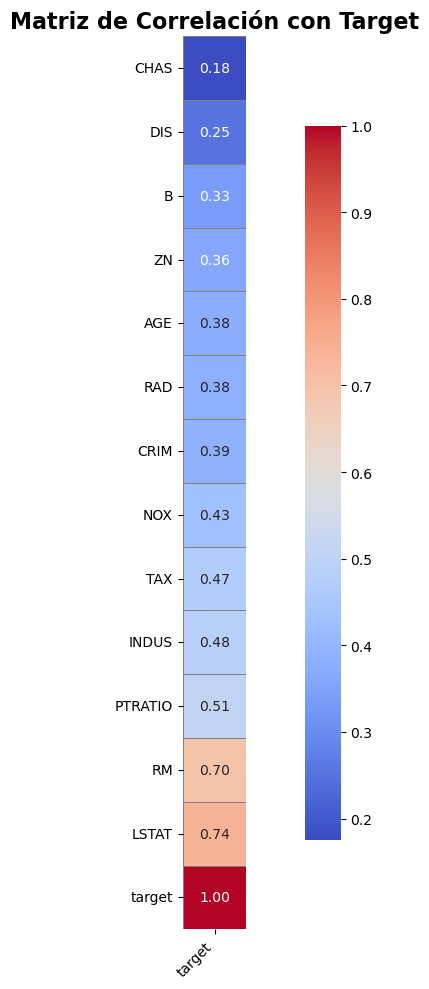

In [26]:
plt.figure(figsize=(12, 10))  # Ajuste de tamaño más equilibrado

sns.heatmap(
    target_corr_abs_sort,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8},
    square=True
)

plt.title('Matriz de Correlación con Target', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Correlación entre features

In [27]:
mask = np.triu(df_corr)

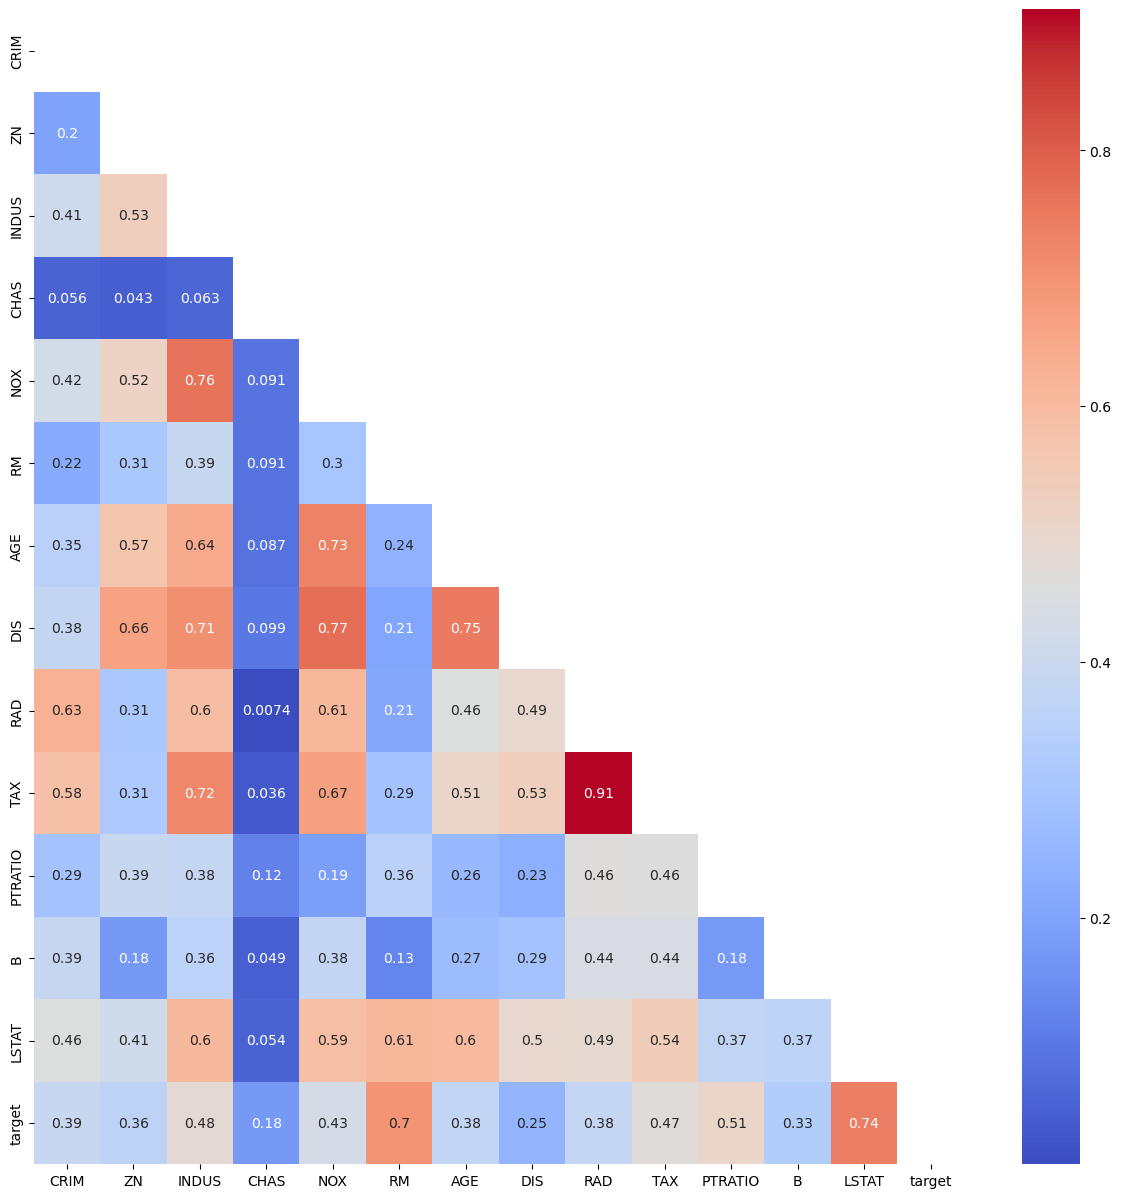

In [28]:
plt.figure(figsize=(15, 15))                     # Inicializa la figura y el eje con un tamaño de 10×10 pulgadas

sns.heatmap(                                               # Dibuja el mapa de calor de las correlaciones
    df_corr,                                             #   ▶️ matriz de correlaciones
    mask=mask,                                             #   ▶️ aplica la mársara para mostrar solo el triángulo inferior
    cmap='coolwarm',                                       #   ▶️ usa la paleta de colores definida                                         #   ▶️ celdas cuadradas para una distribución uniforme
    annot=True                                             #   ▶️ muestra el valor numérico de cada correlación
)

plt.show()

#### Distribución de columna target

In [30]:
target_mean = np.mean(df['target'])
target_median = np.median(df['target'])

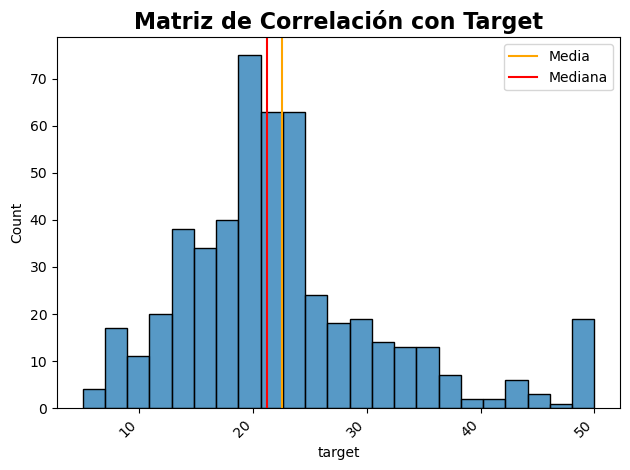

In [31]:
plt.title('Matriz de Correlación con Target', fontsize=16, fontweight='bold')
sns.histplot(data=df, x="target")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.axvline(target_mean, color='orange', label='Media')
plt.axvline(target_median, color='red', label='Mediana')
plt.legend()
plt.tight_layout()
plt.show()

### Breve preprocesamiento

#### Reducción de dimensionalidad (manual)

In [32]:
target_corr_abs_sort_top_features = target_corr_abs_sort.index[1:5]
target_corr_abs_sort_top_features

Index(['DIS', 'B', 'ZN', 'AGE'], dtype='object')

In [33]:
selected = set(target_corr_abs_sort_top_features)

for i in range(len(df_corr.columns)):
    for j in range(i):
        f1 = df_corr.columns[i]
        f2 = df_corr.columns[j]

        try:
            if df_corr.iloc[i, j] > 0.70:
                if target_corr_abs_sort[f1] > target_corr_abs_sort[f2]:
                    selected.dirsard(f2)
                else:
                    selected.dirsard(f1)
        except:
            pass

#### Tratamiento de outliers sobre target

In [34]:
p_01 = df['target'].quantile(0.01)
p_99 = df['target'].quantile(0.99)

In [35]:
df['target'] = np.clip(df['target'], p_01, p_99)

#### Particion de datos

In [36]:
X = df.drop(["target"], axis=1)   # Selecciona TODAS las columnas excepto 'target' ⇒ variables predictoras (features)
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [37]:
y = df["target"].copy()           # Copia la columna objetivo ⇒ valores a predecir (evitamos modificaciones accidentales)
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: target, Length: 506, dtype: float64

In [38]:
# Divide el dataset: 80 % para entrenamiento y 20 % para prueba
# - test_size=0.2   → 20 % de las filas se reservan para evaluar el modelo
# - random_state=42 → fija la “semilla” para que el split sea siempre igual (reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)  # ← dimensiones de las features de entrenamiento
print(X_test.shape)   # ← dimensiones de las features de prueba
print(y_train.shape)  # ← longitud del vector objetivo de entrenamiento
print(y_test.shape)   # ← longitud del vector objetivo de prueba

(404, 13)
(102, 13)
(404,)
(102,)


#### Ersalamiento 

In [40]:
rs = RobustScaler()

In [41]:
rs.fit(X_train)

RobustScaler()

In [42]:
X_train = pd.DataFrame(data=rs.transform(X_train), columns=X_train.columns, index = X_train.index)
X_test = pd.DataFrame(data=rs.transform(X_test), columns=X_test.columns, index = X_test.index)

### Modelado

#### Instancia

In [43]:
lr_model = LinearRegression()

#### Entrenamiento

In [44]:
lr_model.fit(X_train, y_train)

LinearRegression()

#### Predicciones

In [45]:
y_train_pred = lr_model.predict(X_train)

In [46]:
y_test_pred = lr_model.predict(X_test)

#### Evaluación

##### Distribución de los errores

In [48]:
errores = y_test - y_test_pred
errores

173    -5.389399
274    -3.619597
491    -1.218365
72     -2.227449
452    -2.682311
         ...    
412    18.032138
436    -4.080482
411     1.019847
86      0.215695
75     -3.072243
Name: target, Length: 102, dtype: float64

In [ ]:
media_errores = np.mean(errores)
mediana_errores = np.median(errores)
std_errores = np.std(errores)

In [70]:
# Crear rango continuo para la curva teórica
x = np.linspace(min(errores), max(errores), 300)
pdf = norm.pdf(x, media_errores, std_errores)

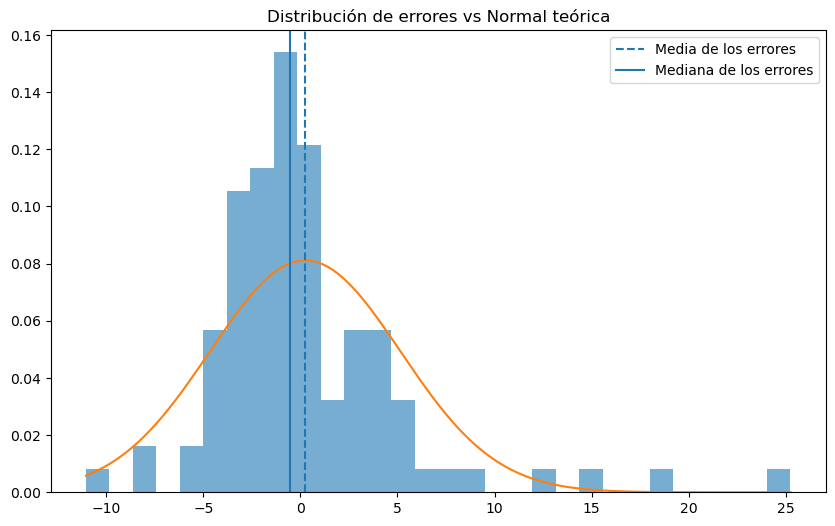

In [73]:
plt.figure(figsize=(10, 6))

# Histograma normalizado
plt.hist(errores, bins=30, density=True, alpha=0.6)

# Curva normal teórica
plt.plot(x, pdf)

# Media y mediana
plt.axvline(media_errores, linestyle='--', label='Media de los errores')
plt.axvline(mediana_errores, linestyle='-', label='Mediana de los errores')

plt.legend()

plt.title("Distribución de errores vs Normal teórica")
plt.show()

La distribución de errores presenta una forma aproximadamente normal en la región central, pero evidencia asimetría positiva y cola derecha más pesada, lo que indica desviaciones respecto a la normalidad.

- El modelo no tiene sesgo global fuerte (Media ≈ mediana ≈ 0)

- La distribución de errores no parece perfectamente normal pero tampoco es gravemente asimétrica. Lo que sugiere errores grandes ocasionales (cola derecha), lo que a su vez indica que puede estar subestimando algunos valores grandes

Se utilizarán MAE y RMSE como métricas principales de error, ya que permiten evaluar tanto la magnitud promedio del error (MAE) como la penalización de errores grandes (RMSE). No se empleará MAPE debido a la presencia de valores cercanos a cero, que pueden generar inestabilidad en métricas porcentuales. Además, se reportará R² como medida de ajuste global, ya que en el contexto de regresión lineal permite interpretar la proporción de varianza explicada por el modelo.

In [77]:
def regression_report(y_true, y_pred, n_features=None):
    """
    Prints a regression metrics summary report.
    
    Handles NaNs automatically and computes RMSLE only on non-negative values.
    """
    import numpy as np
    from sklearn.metrics import (
        mean_absolute_error,
        median_absolute_error,
        max_error,
        mean_squared_error,
        r2_score,
        explained_variance_score,
        mean_absolute_percentage_error
    )

    # ==========================
    # Filtrar NaNs para todas las métricas
    # ==========================
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    n = len(y_true_clean)

    # ==========================
    # Métricas de error absoluto
    # ==========================
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    medae = median_absolute_error(y_true_clean, y_pred_clean)
    max_err = max_error(y_true_clean, y_pred_clean)

    # MASE: normalizado por la media del cambio absoluto
    if n > 1:
        mase = mae / np.mean(np.abs(np.diff(y_true_clean)))
    else:
        mase = np.nan

    # ==========================
    # Métricas de error cuadrático
    # ==========================
    mse = mean_squared_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mse)

    # RMSLE solo para valores no negativos
    mask_rmsle = (y_true_clean >= 0) & (y_pred_clean >= 0)
    if np.any(mask_rmsle):
        rmsle = np.sqrt(mean_squared_error(
            np.log1p(y_true_clean[mask_rmsle]),
            np.log1p(y_pred_clean[mask_rmsle])
        ))
    else:
        rmsle = np.nan

    # ==========================
    # Métricas de error porcentual
    # ==========================
    try:
        mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    except:
        mape = np.nan

    smape = np.mean(
        2 * np.abs(y_pred_clean - y_true_clean) /
        (np.abs(y_true_clean) + np.abs(y_pred_clean) + 1e-8)  # evitar división por 0
    )

    wape = np.sum(np.abs(y_true_clean - y_pred_clean)) / (np.sum(np.abs(y_true_clean)) + 1e-8)

    # ==========================
    # Goodness of fit
    # ==========================
    r2 = r2_score(y_true_clean, y_pred_clean)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1) if n_features else None
    explained_var = explained_variance_score(y_true_clean, y_pred_clean)

    # ==========================
    # Impresión del reporte
    # ==========================
    print("=" * 60)
    print(" " * 20 + "REGRESSION REPORT")
    print("=" * 60)
    print(f"\nObservations: {n}")
    if n_features:
        print(f"Features:     {n_features}")
    print("-" * 60)

    print("\nERROR METRICS (Absolute Scale)")
    print(f"MAE:                     {mae:.4f}")
    print(f"Median Absolute Error:   {medae:.4f}")
    print(f"Max Error:               {max_err:.4f}")
    print(f"MASE:                    {mase:.4f}")

    print("\nSQUARED ERROR METRICS")
    print(f"MSE:                     {mse:.4f}")
    print(f"RMSE:                    {rmse:.4f}")
    print(f"RMSLE:                   {rmsle:.4f}")

    print("\nPERCENTAGE ERROR METRICS")
    print(f"MAPE:                    {mape:.4%}")
    print(f"SMAPE:                   {smape:.4%}")
    print(f"WAPE:                    {wape:.4%}")

    print("\nGOODNESS OF FIT")
    print(f"R²:                      {r2:.4f}")
    if adj_r2:
        print(f"Adjusted R²:             {adj_r2:.4f}")
    print(f"Explained Variance:       {explained_var:.4f}")
    print("=" * 60)

In [78]:
regression_report(y_true=y_test, y_pred=y_test_pred)

                    REGRESSION REPORT

Observations: 102
------------------------------------------------------------

ERROR METRICS (Absolute Scale)
MAE:                     3.1823
Median Absolute Error:   2.3249
Max Error:               25.2500
MASE:                    0.3307

SQUARED ERROR METRICS
MSE:                     24.2481
RMSE:                    4.9242
RMSLE:                   0.1949

PERCENTAGE ERROR METRICS
MAPE:                    16.6846%
SMAPE:                   17.7680%
WAPE:                    14.7958%

GOODNESS OF FIT
R²:                      0.6665
Explained Variance:       0.6674


El RMSE (4.92) es mayor que el MAE (3.18), lo que indica que existen errores grandes que dominan parte del desempeño del modelo, más que un sesgo sistemático. Por su parte, R² = 0.66 muestra que el modelo logra explicar aproximadamente el 66% de la varianza de la variable objetivo, lo que representa un ajuste global razonable. En conjunto, estas métricas sugieren que el modelo captura bien la estructura general de los datos, aunque algunos errores grandes impactan significativamente en el performance.